# Travail pratique 2
*INF600F - Traitement d'images (H2022, UQÀM)*

In [300]:
# Importation des modules pertinents ici. 
# Assurez-vous d'inclure toute autre fonction que vous
# jugez nécessaires ici

import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter, convolve
from skimage. transform import rescale


# importation d'images

EX1_PAD = np.mean(imageio.imread("image_00.jpg"), axis=2)
EX2_FREQ = imageio.imread("tp2_ex2.tif")
EX3_FILTRE = imageio.imread("tp2_ex3.tif")

# Exercice 1 : Filtrage spatial (9 pts)

In [301]:
def _creer_both(f: np.ndarray, r: int, c: int, padType: str) -> np.ndarray:
    
    f_p = np.zeros((f.shape[0] + r*2, f.shape[1] + c*2))
    f_p[r:-r, c:-c] = f

    if padType != "zeros":
        f_p[:r, c:-c] = f[-r:,:] # cote haut
        f_p[-r : , c:-c] =  f[:r, :] # cote bas
        f_p[r:-r, :c] = f[:, -c:] # cote gauche
        f_p[r:-r, -c:] = f[:, :c] # cote droit
        f_p[:r, :c] = f[-r:, -c:] # coin haut-gauche
        f_p[:r, -c:] = f[-r:, :c] # coin haut-droit
        f_p[-r:, :c] = f[:r, -c:] # coin bas-gauche
        f_p[-r:, -c:] = f[:r, :c] # coin bas-droit
    return f_p

In [302]:
def _creer_post(f: np.ndarray, r: int, c: int, padType: str) -> np.ndarray:
    f_p = np.zeros((f.shape[0] + r, f.shape[1] + c)) 
    f_p[:-r, :-c] = f
    if padType != "zeros":
        f_p[-r : , :-c] =  f[:r, :] # cote bas
        f_p[:-r, -c:] = f[:, :c] # cote droit
        f_p[-r:, -c:] = f[:r, :c] # coin bas-droit

        
    return f_p

In [303]:
def imgPad(f, r, c, padType='zeros', loc='both'):
    """Ajoute un padding à une image
    
    Parameters
    ----------
    f : ndarray
        Image à modifier
    r : int
        Taille du padding pour les lignes
    c : int
        Taille du padding pour les colonnes
    padType : str
        Type de padding. Valeurs possibles : 'zeros', 'replicate'
    loc : str
        Position du padding. Valeurs possibles : 'both' ou 'post'
    Returns
    -------
    f_p : ndarray
        Image avec un padding ajouté
    """
    if padType not in ["zeros", "replicate"] :
        raise ValueError(f"Erreur dans le paramètre 'padType' = {padType}. Valeurs valides : 'zeros' | 'replicate'.")
    if loc not in ["post", "both"] :
        raise ValueError(f"Erreur dans le paramètre 'loc' = {loc}. Valeurs valides : 'both' | 'post'.")
    f_copy = f.copy()
    return _creer_both(f_copy, r, c, padType) if loc == "both" else _creer_post(f_copy,r,c, padType)

    

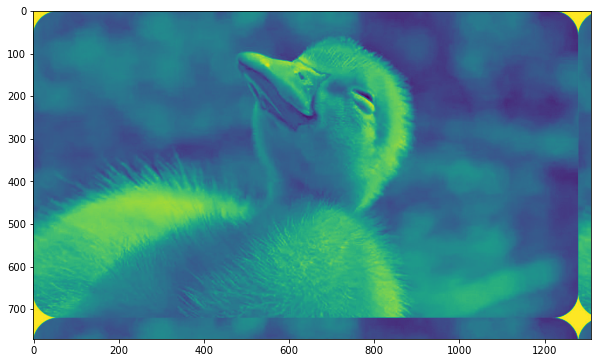

In [304]:
padded = imgPad(EX1_PAD, 50, 30,loc="post", padType="replicate")


plt.figure(figsize=(10,10))
plt.subplot(111)
plt.imshow(padded)
plt.show()

In [305]:
def twodConv(f, w, normalize=True):
    """ Effectue une convolution 2D de l'image f avec le noyau w

    Parameters
    ----------
    f : ndarray
        Image convoluer
    w : ndarray
        Noyau/filtre pour la convolution
    normalize : bool
        Si True, les intensités de l'image f doivent être normalisées entre 0 et 1
    Returns
    -------
    f_p : ndarray
        Image convoluée
    Notes
    -----
    * La fonction imgPad créée dans la partie précédente doit être utilisée.
    """
    f_p = imgPad(f, w.shape[0], w.shape[1], loc="both", padType="zeros")

    if normalize :
        f_p = (f_p - f_p.min()) / (f_p.max() - f_p.min())
    

    f_p = convolve(f_p, w)
    
    f_p = f_p[w.shape[0]: - w.shape[0], w.shape[1]:-w.shape[1]]
    
    
    return f_p

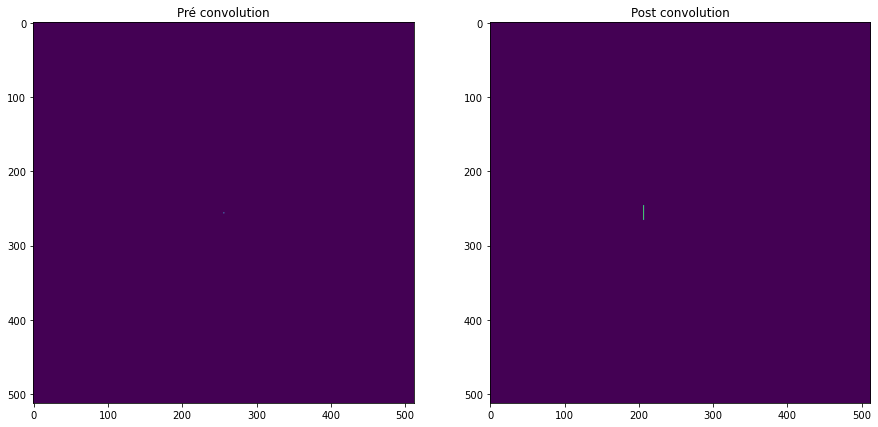

In [311]:


img = np.zeros((512,512))
img[256,256] = 1


filtre_g = np.zeros((20,200))
filtre_g[:,0] = 1

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Pré convolution")
plt.imshow(img)
plt.subplot(122)
plt.title("Post convolution")
plt.imshow(twodConv(img, filtre_g, False))
plt.show()



# Exercice 2 : Transformée de Fourier (6 pts)

In [307]:
# Ajouter ici des cellules de code / markdown pour vos réponses

In [308]:
def display_fft(img_fft):
    """Affichage de l'amplitude et de la phase d'une transformée de Fourier
    
    Parameters
    ----------
    img_fft : ndarray
        Transformée de Fourier d'une image
    """
    # Votre code ici
    pass

# Exercice 3 : Filtrage fréquentiel (10 pts)

In [309]:
# Ajouter ici des cellules de code / markdown pour vos réponses

In [310]:
def lpFilterTF(type, P, Q, param):
    """Crée un filtre passe bas fréquentiel
    
    Parameters
    ----------
    type : str
        Type de filtre. Valeurs possibles : 'ideal', 'gaussian', 'butterworth'
    P : int
        Nombre de ligne du filtre
    Q : int
        Nombre de colonne du filtre
    param : float ou list
        Si type='ideal' ou type='gaussian', param=d0
        Si type='butterworth', type=[d0,n]

    Returns
    -------
    H : ndarray
        Filtre fréquentiel passe bas de taille PxQ
    
    """
    # Votre code ici
    pass